In [ ]:
import os 
import glob 
import xarray as xr 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import shutil
from scipy.stats import linregress
import cartopy.io.shapereader as shpreader
from shapely.geometry import shape
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from shapely.prepared import prep
import regionmask
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import xesmf as xe
from matplotlib.ticker import ScalarFormatter
from shapely.geometry import Point
import matplotlib.cm as cm
import calendar
from collections import Counter
import itertools
import rasterio
import struct
from datetime import datetime

# Set global font to a sans-serif type suitable for publishing
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],  # Use 'Helvetica' or 'DejaVu Sans' if Arial is unavailable
    'font.size': 8,               # Default font size
    'axes.titlesize': 8,          # Title font size
    'axes.labelsize': 8,          # X and Y labels font size
    'xtick.labelsize': 8,         # X-axis tick labels font size
    'ytick.labelsize': 8,         # Y-axis tick labels font size
    'legend.fontsize': 8,         # Legend font size
    'figure.titlesize': 8         # Figure title font size
})

# Change inputs

Files structure is .$home/PRISM/{var_name}/netdf

In [115]:
home = '/home/ib28/mymount/sd75/isabelleb/wastewater/PRISM'
shapefile = "/home/ib28/mymount/sd75/isabelleb/wastewater/shapefiles/Regional_County_Boundaries.shp"

In [2]:
def parse_header(hdr_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def read_bil_manual(bil_path, hdr_path):
    """
    Reads a .bil file manually using information from its .hdr file.
    """
    header = parse_header(hdr_path)

    nrows = int(header.get('NROWS', 0))
    ncols = int(header.get('NCOLS', 0))
    nbits = int(header.get('NBITS', 0))
    byteorder = header.get('BYTEORDER', 'I') # 'I' for Intel (little-endian), 'M' for Motorola (big-endian)
    pixeltype = header.get('PIXELTYPE', 'SIGNEDINT') # Example: FLOAT, SIGNEDINT, UNSIGNEDINT

    # Determine data type for struct and numpy
    if nbits == 8:
        dtype = np.int8 if pixeltype == 'SIGNEDINT' else np.uint8
        fmt_char = 'b' if pixeltype == 'SIGNEDINT' else 'B'
    elif nbits == 16:
        dtype = np.int16 if pixeltype == 'SIGNEDINT' else np.uint16
        fmt_char = 'h' if pixeltype == 'SIGNEDINT' else 'H'
    elif nbits == 32:
        if pixeltype == 'FLOAT':
            dtype = np.float32
            fmt_char = 'f'
        else:
            dtype = np.int32 if pixeltype == 'SIGNEDINT' else np.uint32
            fmt_char = 'i' if pixeltype == 'SIGNEDINT' else 'I'
    else:
        raise ValueError(f"Unsupported NBITS: {nbits}")

    endian_prefix = '<' if byteorder == 'I' else '>' # Little-endian or Big-endian

    with open(bil_path, 'rb') as f:
        bil_data = f.read()

    # Unpack binary data
    num_elements = nrows * ncols
    format_string = f"{endian_prefix}{num_elements}{fmt_char}"
    unpacked_data = struct.unpack(format_string, bil_data)

    # Reshape into a 2D array
    data_array = np.array(unpacked_data, dtype=dtype).reshape(nrows, ncols)

    return data_array

# Example usage:
bil_file = os.path.join('tmean', 'PRISM_tmean_stable_4kmM3_202101_bil.bil') 
hdr_file = os.path.join('tmean', 'PRISM_tmean_stable_4kmM3_202101_bil.hdr') 
bil_data_manual = read_bil_manual(bil_file, hdr_file)

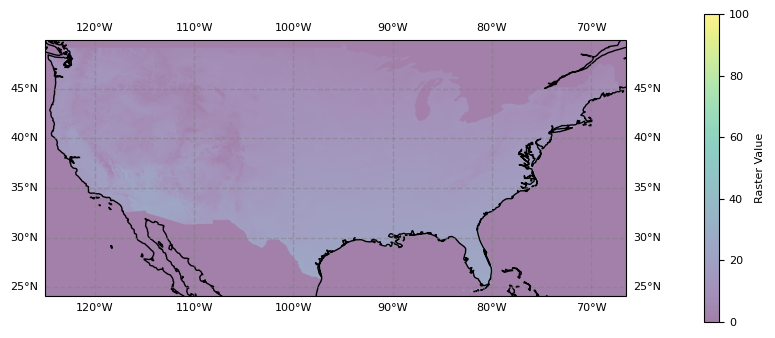

In [3]:
# Read raster data from .bil file
bil_file_path = os.path.join('tmean', 'PRISM_tmean_stable_4kmM3_2021_bil.bil') 

# Use rasterio to read the raster data
with rasterio.open(bil_file_path) as src:
    raster_data = src.read(1)
    transform = src.transform

# Visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the desired minimum and maximum values for the colormap
vmin = 0  
vmax = 100  

# Plot the raster data using imshow with vmin and vmax
im = ax.imshow(raster_data, extent=(transform[2], transform[2] + transform[0] * raster_data.shape[1],
                                    transform[5] + transform[4] * raster_data.shape[0], transform[5]),
               origin='upper', cmap='viridis', alpha=0.5, vmin=vmin, vmax=vmax)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, shrink=0.4)
cbar.set_label('Raster Value')

# Add gridlines and coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines()

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

plt.show()

In [28]:
# Convert the data into an xarray dataset 

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

header_data = parse_header(hdr_file)
x0 = float(header_data['ULXMAP'])
y0 = float(header_data['ULYMAP'])
dx = float(header_data['XDIM'])
dy = float(header_data['YDIM'])
    
Nx = raster_data.shape[1]
Ny = raster_data.shape[0]
# dx = transform[0]
# dy = transform[4]
# x0 = transform[2]
# y0 = transform[5] 
    
longitude = create_array_with_step(Nx, x0, dx)
latitude = create_array_with_step(Ny, y0, -dy) 
filename_parts = bil_file_path.split('.')[0].split('_') 
timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
var_data = np.expand_dims(raster_data, axis=2)

In [30]:
ds = xr.Dataset(
    data_vars=dict(
        tmean=(('lat', 'lon', 'time'), var_data),
    ),
    coords=dict(
        lon=('lon', longitude),
        lat=('lat', latitude),
        time=('time', timestamp), 
    ),
    attrs=dict(description="PRISM data"),
)

<GeoAxes: title={'center': 'time = 2021-01-01'}, xlabel='lon', ylabel='lat'>

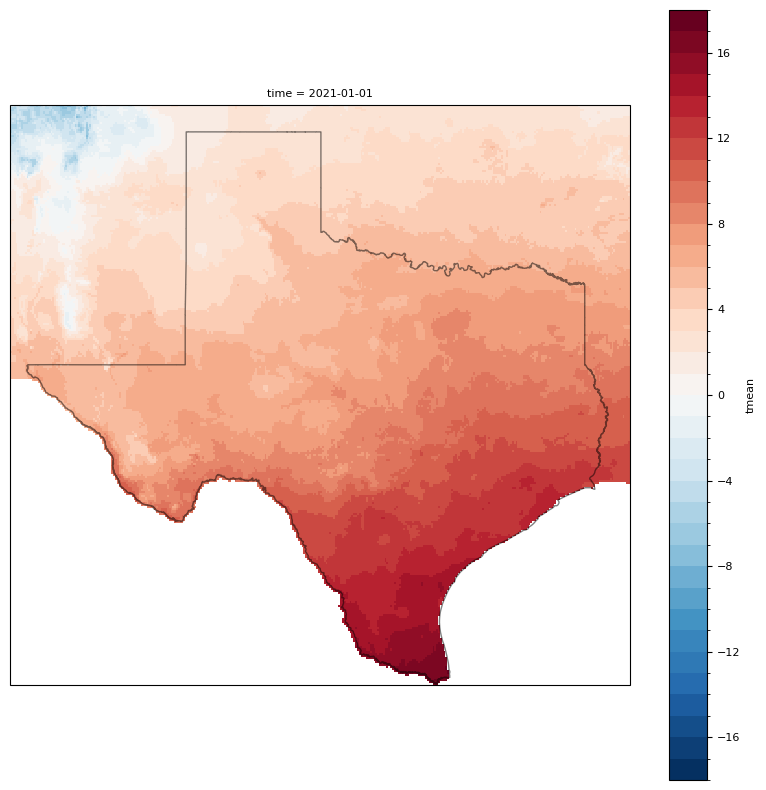

In [32]:

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.arange(-10, 31, 1) 
ds = ds.sortby('lat') 
ds_plot = ds.sel(lat = slice(25, 37), lon = slice(-107, -93)) 
ds_plot = ds_plot.where(ds_plot.tmean > -8000, drop = True) 
levels = np.arange(-18, 19, 1)
ds_plot.sel(time = '20210101').tmean.plot(x = 'lon', y = 'lat', ax = ax, levels = levels)

shapefile = '/home/ib28/mymount/sd75/isabelleb/BWF_Pres/tl_2024_us_state.shp'
states = gpd.read_file(shapefile)

##### Filter for Texas #####
texas = states[states['NAME'] == 'Texas']

##### Plot Texas Boundary #####
texas.boundary.plot(ax=ax, color='black', alpha = 0.5, linewidth=1)

# Read all datasets into NetCDF format

In [113]:
def parse_header(hdr_file_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def parse_bil(bil_file_path): 
    # Use rasterio to read the raster data
    with rasterio.open(bil_file_path) as src:
        raster_data = src.read(1)
    return raster_data       

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

In [114]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2021', '2022', '2023']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for var in variables:
    
    homedir = f'{var}'

    outdir = os.path.join(home, homedir, 'netcdf') 
    if os.path.exists(outdir) == False: 
        os.mkdir(outdir) 
    for year in years: 
        for m in months: 
            bil_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.bil') 
            hdr_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.hdr') 
    
            outfile = os.path.join(home, outdir, f'PRISM_{var}_stable_4kmM3_{year}{m}.nc')
    
            # Read in raster data 
            raster_data = parse_bil(bil_file) 
            Nx = raster_data.shape[1]
            Ny = raster_data.shape[0]
    
            # Read in header data 
            hdr_data = parse_header(hdr_file) 
            x0 = float(hdr_data['ULXMAP'])
            y0 = float(hdr_data['ULYMAP'])
            dx = float(hdr_data['XDIM'])
            dy = float(hdr_data['YDIM'])
    
            # Create coordinate arrays for dataset 
            longitude = create_array_with_step(Nx, x0, dx)
            latitude = create_array_with_step(Ny, y0, -dy) 
            filename_parts = bil_file.split('.')[0].split('_') 
            timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
            var_data = np.expand_dims(raster_data, axis=2)
    
            # Create dataset 
            ds = xr.Dataset(
                data_vars=dict(
                    tmp=(('lat', 'lon', 'time'), var_data),
                ),
                coords=dict(
                    lon=('lon', longitude),
                    lat=('lat', latitude),
                    time=('time', timestamp), 
                ),
                attrs=dict(description=f"PRISM {var} data"),
            )
            ds = ds.rename({'tmp':var})
    
            # Save dataset 
            ds.to_netcdf(outfile) 

# Get values in Harris County 

In [116]:
##### -------- Get KG Classes for Texas -------- #####

##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
counties = gpd.read_file(shapefile)

# ##### Filter for HC #####
HC = counties[counties.NAME == 'Harris']

##### Read in files #####
variables = ['tmean', 'tdmean', 'ppt'] 
for var in variables: 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = glob.glob(os.path.join(home, homedir, '*.nc'))
    files.sort() 

    for f in files: 
        filename = f.split('/')[-1].split('.')[0]
        outfile = os.path.join(home, homedir, f'Harris_County_{filename}.nc') 
        # if os.path.exists(outfile): 
        #     os.remove(outfile) 
        with xr.open_dataset(f) as ds: 

            # Limit file 
            ds = ds.sortby('lat') 
            ds = ds.sel(lon = slice(-96.5, -94.5), lat = slice(29.1, 30.5))
            
            # Get the lat/lon coordinates
            lats = ds['lat'].values
            lons = ds['lon'].values
    
            # Create a 2D mesh of coordinates
            lon2d, lat2d = np.meshgrid(lons, lats)
    
            # Flatten the mesh for easier masking
            points = np.array([Point(xy) for xy in zip(lon2d.ravel(), lat2d.ravel())])
    
            # Check which points fall inside the HC polygon
            within_HC = np.array([HC.geometry.iloc[0].contains(p) for p in points])
            mask = within_HC.reshape(lat2d.shape)
    
            # Apply mask to data
            # If 3D (time, lat, lon)
            if "time" in ds.dims:
                mask = np.expand_dims(mask, axis=2)
                masked = ds.where(mask)
            else:
                # 2D (lat, lon)
                masked = ds.where(mask)
            
            # Save data 
            masked.to_netcdf(outfile) 

Text(0.5, 0.77, '2021-01 Mean Monthly Temperature in Harris County')

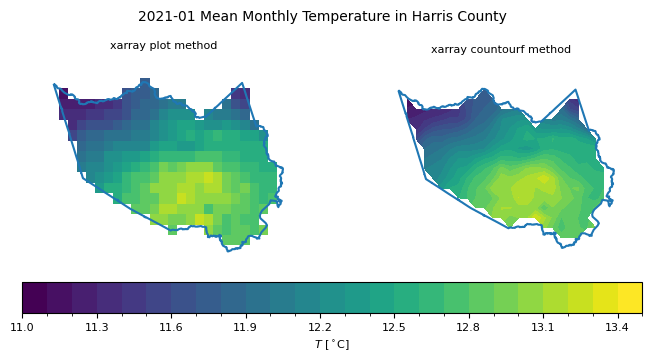

In [119]:
# Plot the Harris County data for 202101 to check 
HC_bounds = [-96.1, -94.8, 29.45, 30.25]

var = 'tmean'
date = '202101'
year = date[:4]
mon = date[4:]
datestr = f'{date}01'

fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (8, 5))

# ax.set_xlim(HC_bounds[0], HC_bounds[1]) 
# ax.set_ylim(HC_bounds[2], HC_bounds[3]) 

# Plot tmean 
infile = os.path.join(home, f'{var}', 'netcdf', f'Harris_County_PRISM_{var}_stable_4kmM3_{date}.nc') 
ds = xr.open_dataset(infile) 
ds = ds.sel(time = datestr, lon = slice(HC_bounds[0], HC_bounds[1]), lat = slice(HC_bounds[2], HC_bounds[3]))
levels = np.arange(11, 13.6, 0.1) 
CS = ds[var].plot(x = 'lon', y = 'lat', ax = ax[0], add_colorbar = False, levels = levels) 
CS = ds[var].plot.contourf(x = 'lon', y = 'lat', ax = ax[1], add_colorbar = False, levels = levels) 
ax[0].set_title('xarray plot method') 
ax[1].set_title('xarray countourf method') 

# Plot HC boundary 
for i in range(2): 
    counties = gpd.read_file(shapefile)
    HC = counties[counties.NAME == 'Harris']
    HC.boundary.plot(ax = ax[i]) 
    
    # Plot Characteristics 
    ax[i].axis('off') 
plt.colorbar(CS, ax = ax, orientation = 'horizontal', pad = 0.04, label = r'$T$ [$^\circ$C]') 
plt.suptitle(f'{year}-{mon} Mean Monthly Temperature in Harris County', y=0.77, fontsize = 10) 

# Time series of variables averaged over Harris County 

In [120]:
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [ ]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2021', '2022', '2023'] 
for var in variables: 
    for year in years: 
        homedir = os.path.join(home, f'{var}', 'netcdf') 
        files = glob.glob(os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4kmM3_{year}*.nc'))
        files.sort() 
    
        ds = xr.open_mfdataset(files, concat_dim = 'time', combine = 'nested').load() 
    
        outfile = os.path.join(home, homedir, f'Harris_PRISM_{var}_stable_4kmM3_{year}.nc')
        ds.to_netcdf(outfile) 

Text(0, 0.5, 'Precpiptation [mm]')

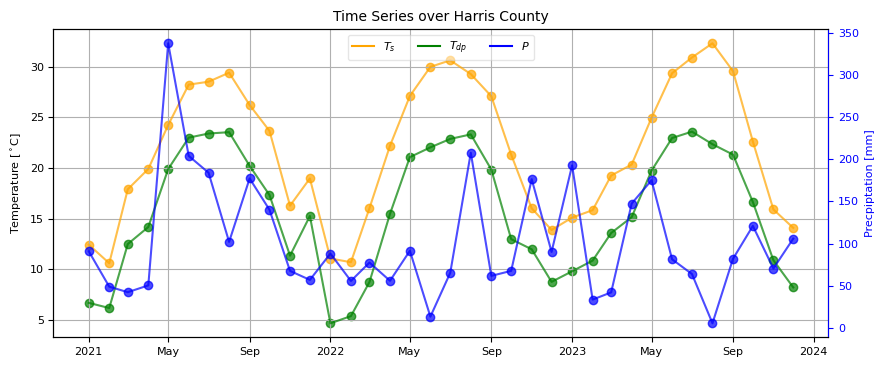

In [122]:
variables = ['tmean', 'tdmean', 'ppt'] 
colors = ['orange', 'green', 'blue'] 
years = ['2021', '2022', '2023'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 

for i, var in enumerate(variables): 
    color = colors[i]
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir, f'Harris_PRISM_{var}_stable_4kmM3_{year}.nc')) 
        
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    
    if var == 'ppt': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(color)
        twin1.tick_params(axis='x', colors=color)
        twin1.tick_params(axis='y', colors=color)
        twin1.set_ylabel('Precpiptation [mm]', color = color) 
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x = 'time', ax = axplot, color=color, alpha = 0.7) 
    ds_mean[var].plot.scatter(x = 'time', ax = axplot, color=color, alpha = 0.7) 
        
# Add a legend manually if needed
labels = ['$T_{s}$', r'$T_{dp}$', r'$P$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10) 
twin1.set_ylabel('Precpiptation [mm]', color = color)

# Back Calculate Relative Humidity

In [123]:
def rel_humidity(tas, tdp): 
    ''' 
    Calculates relative humidty (%) using the Mangus approximation 

    Inputs:
    tas - surface temperature (C)
    tdp - dew point temperature (C)

    Outputs:
    hurs - surface relative humidity (%)
    '''
    # Constants
    c1 = 17.625
    c2 = 243.04

    # Mangus Forumla
    hurs = 100*(np.exp((c1*tdp)/(c2+tdp))/np.exp((c1*tas)/(c2+tas)))

    return hurs 

In [125]:
outdir = 'hurs'
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 

for year in years: 

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_PRISM_tmean_stable_4kmM3_{year}.nc'))
    files_tmean.sort() 
    files_tdmean = glob.glob(os.path.join(home, 'tdmean', 'netcdf', f'Harris_PRISM_tdmean_stable_4kmM3_{year}.nc'))
    files_tdmean.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_tdmean = xr.open_mfdataset(files_tdmean, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(home, outdir, f'Harris_PRISM_hurs_stable_4kmM3_{year}.nc')

    # Calculate relhum: 
    ds_hurs = rel_humidity(ds_tmean.tmean, ds_tdmean.tdmean)

    # Save as netcdf 
    ds_hurs = ds_hurs.to_dataset(name = 'hurs')
    ds_hurs.to_netcdf(outfile)
    

Text(0.5, 1.0, 'Relative Humidity over Harris County')

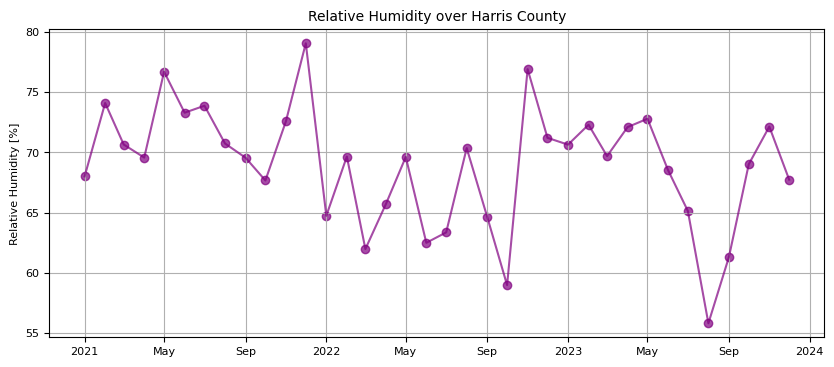

In [126]:
years = ['2021', '2022', '2023'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
var = 'hurs'

homedir = os.path.join(home, f'{var}', 'netcdf') 
files = []
for year in years: 
    files.append(os.path.join(home, homedir, f'Harris_PRISM_{var}_stable_4kmM3_{year}.nc')) 
    
ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

# Get mean 
ds_mean = weighted_mean(ds, 'lat', 'lon')

# Plot 
ds_mean[var].plot(x = 'time', ax = ax, color='purple', alpha = 0.7, label = r'$r$') 
ds_mean[var].plot.scatter(x = 'time', ax = ax, color='purple', alpha = 0.7) 


# ax.legend(loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Relative Humidity [%]') 
ax.grid() 
ax.set_title('Relative Humidity over Harris County', fontsize = 10) 

# Calculate wet bulb temperature 

In [127]:
def stull_wet_bulb_temp(tas, hurs):
    '''
    Calculates the approximation for wet bulb temperature developed by Stull et al (2011)

    Inputs:
    tas - surface temperature (C)
    hurs - relative humidity (%)

    Outputs:
    twbs - wet bulb temperature (C)
    '''

    # Constants
    c1 = 0.151977
    c2 = 8.313659
    c3 = 1.676331
    c4 = 0.00391838
    c5 = 0.023101
    c6 = 4.686035

    # Calculate wet bulb temperature
    twbs = tas * np.arctan(c1 * (hurs + c2)**(0.5)) + np.arctan(tas + hurs) - np.arctan(hurs - c3) + c4 * (hurs)**(1.5) * np.arctan(c5 * hurs) - c6

    return twbs


In [128]:
outdir = 'twbs'
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir)     

for year in years: 

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_PRISM_tmean_stable_4kmM3_{year}.nc'))
    files_tmean.sort() 
    files_hurs = glob.glob(os.path.join(home, 'hurs', f'Harris_PRISM_hurs_stable_4kmM3_{year}.nc'))
    files_hurs.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_hurs = xr.open_mfdataset(files_hurs, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(home, outdir, f'Harris_PRISM_twbs_stable_4kmM3_{year}.nc')

    # Calculate relhum: 
    ds_twbs = stull_wet_bulb_temp(ds_tmean.tmean, ds_hurs.hurs)

    # Save as netcdf 
    ds_twbs = ds_twbs.to_dataset(name = 'twbs')
    ds_twbs.to_netcdf(outfile)
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/ib28/mymount/sd75/isabelleb/wastewater/PRISM/twbs/netcdf/netcdf/Harris_PRISM_twbs_stable_4kmM3_2021.nc'

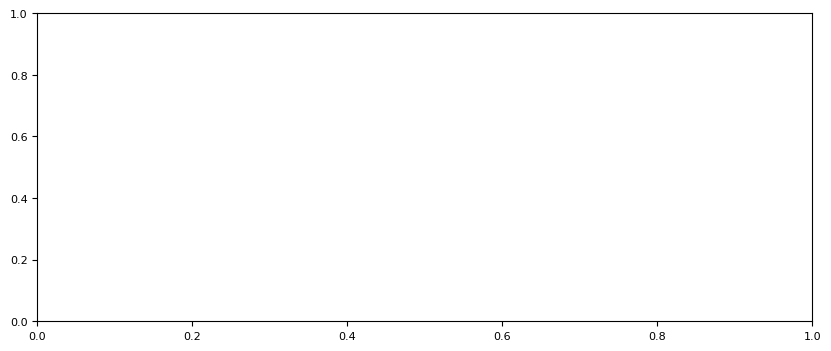

In [129]:
years = ['2021', '2022', '2023'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']

for i,var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir,  f'Harris_PRISM_{var}_stable_4kmM3_{year}.nc')) 
        
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 
    
    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')

    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax
    
    # Plot 
    ds_mean[var].plot(x = 'time', ax = axplot, color=colors[i], alpha = 0.7, label = r'$r$') 
    ds_mean[var].plot.scatter(x = 'time', ax = axplot, color=colors[i], alpha = 0.7) 

labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)
